In [25]:
%matplotlib inline
import matplotlib.pyplot as plt
import time
import sys
import numpy as np
import torch
from PIL import Image
import cv2
from copy import deepcopy
from IPython import embed
from scipy.io import loadmat

sys.path.insert(0, '..')
from isegm.utils import vis, exp

from isegm.inference import utils
from isegm.inference.evaluation import evaluate_dataset, evaluate_sample, infer_sample_no_gt
from tqdm import tqdm

device = torch.device('cuda:0')
cfg = exp.load_config_file('../config.yml', return_edict=True)

from clip_saliency import get_saliency_map

### Init dataset

In [22]:
# Possible choices: 'GrabCut', 'Berkeley', 'DAVIS', 'COCO_MVal', 'SBD'
# PascalVOC
DATASET = 'SBD'
dataset = utils.get_dataset(DATASET, cfg)

### Init model

In [23]:
from isegm.inference.predictors import get_predictor

EVAL_MAX_CLICKS = 20
MODEL_THRESH = 0.49

checkpoint_path = utils.find_checkpoint(cfg.INTERACTIVE_MODELS_PATH, 'coco_lvis_h18s_itermask')
model = utils.load_is_model(checkpoint_path, device)

# Possible choices: 'NoBRS', 'f-BRS-A', 'f-BRS-B', 'f-BRS-C', 'RGB-BRS', 'DistMap-BRS'
brs_mode = 'f-BRS-B'
predictor = get_predictor(model, brs_mode, device, prob_thresh=MODEL_THRESH)

In [24]:
VOC_LUT = {1: 'aeroplane',
2: 'bicycle',
3: 'bird',
4: 'boat',
5: 'bottle',
6: 'bus',
7: 'car',
8: 'cat',
9: 'chair',
10: 'cow',
11: 'diningtable',
12: 'dog',
13: 'horse',
14: 'motorbike',
15: 'person',
16: 'pottedplant',
17: 'sheep',
18: 'sofa',
19: 'train',
20: 'tvmonitor'}

### NoC (Interactive Seg Benchmark) evaluation

In [13]:
from isegm.inference.clicker import Click

TARGET_IOU = 0.9
CLIP_PROMPT = True

all_ious = []

start_time = time.time()
for index in tqdm(range(len(dataset)), leave=False):
    sample = dataset.get_sample(index)

    if CLIP_PROMPT:
        real_class_id = sample.real_class_id
        text_queries = [f'an image of a {VOC_LUT[real_class_id]}']
        clip_saliency_map = get_saliency_map(sample.image, text_queries)
        max_point = np.unravel_index(clip_saliency_map.argmax(), clip_saliency_map.shape)
        init_clicks = [Click(is_positive=True, coords=max_point)]
    else:
        init_clicks = None

    _, sample_ious, _ = evaluate_sample(sample.image, sample.gt_mask, predictor,
                                        sample_id=index, pred_thr=MODEL_THRESH,
                                        max_iou_thr=TARGET_IOU, max_clicks=EVAL_MAX_CLICKS,
                                        init_clicks=init_clicks)
    all_ious.append(sample_ious)
end_time = time.time()
elapsed_time = end_time - start_time

In [14]:
mean_spc, mean_spi = utils.get_time_metrics(all_ious, elapsed_time)
noc_list, over_max_list = utils.compute_noc_metric(all_ious,
                                                   iou_thrs=[0.8, 0.85, 0.9],
                                                   max_clicks=EVAL_MAX_CLICKS)

header, table_row = utils.get_results_table(noc_list, over_max_list, brs_mode, DATASET,
                                            mean_spc, elapsed_time, EVAL_MAX_CLICKS)
print(header)
print(table_row) # Note that NOC results are offsetted by 1

-----------------------------------------------------------------------------------------------
|  BRS Type   |  Dataset  | NoC@80% | NoC@85% | NoC@90% |>=20@85% |>=20@90% | SPC,s |  Time   |
-----------------------------------------------------------------------------------------------
|   f-BRS-B   |    SBD    |  6.94   |  8.39   |  10.78  |  1102   |  2056   | 0.038 | 0:46:56 |


### First click quality evaluation

In [49]:
instance_hit_list = []
semantic_hit_list = []

start_time = time.time()

for index in tqdm(range(len(dataset)), leave=False):
    sample = dataset.get_sample(index)

    # Gather annotations
    ann_path = sample.image_path.replace('SBD/img', 'SBD/cls')
    ann_path = ann_path.replace('.jpg', '.mat')
    semantic_ann = loadmat(ann_path)['GTcls'][0]['Segmentation'][0]
    inst_ann = sample.gt_mask

    # CLIP inquiries
    real_class_id = sample.real_class_id
    text_queries = [f'an image of a {VOC_LUT[real_class_id]}']
    text_queries = ['an image of a train']
    clip_saliency_map = get_saliency_map(sample.image, text_queries)
    max_point = np.unravel_index(clip_saliency_map.argmax(), clip_saliency_map.shape)

    instance_hit_list.append(int(inst_ann[max_point] == 1))
    semantic_hit_list.append(int(semantic_ann[max_point] == real_class_id))
    
    break

end_time = time.time()
elapsed_time = end_time - start_time

In [50]:
np.mean(semantic_hit_list)

0.0

In [51]:
np.mean(instance_hit_list)

0.0

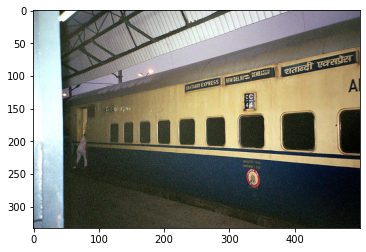

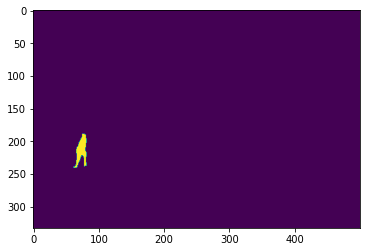

['an image of a train']


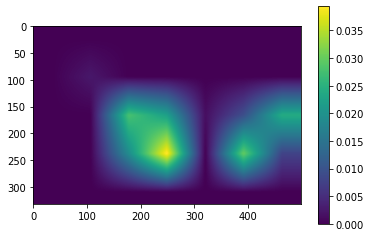

In [52]:
plt.imshow(sample.image)
plt.show()
plt.imshow(sample.gt_mask)
plt.show()
print(text_queries)
plt.imshow(clip_saliency_map)
plt.colorbar()
plt.show()